In this notebook, we will run a ready-made network starting from some ATLAS data, which is already normalized. There is also an alternative to train the network from scratch.  

## Look into the dataset

I used Pickle protocol 4 so that it is not necessary to have a Python 3.8 setup and it can work on any Python 3.4+ version 

In [31]:
#Used Google Colab to optimize the usage of fast ai using GPU backend. Google Colab currently has support only till Python 3.7.
import sys
sys.version


'3.7.10 (default, Feb 20 2021, 21:17:23) \n[GCC 7.5.0]'

We take a pickle dataset, and open into Pandas (after importing pandas). Note that you have to change the paths to the directory where your processed files are. 

In [32]:
#Mounted the Google drive where I uploaded the pickled files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:

import pandas as pd


# paths where I have stored the datasets. 
train_path = 'drive/My Drive/train_cleaned_pickle.pkl'
test_path = 'drive/My Drive/test_cleaned_pickle.pkl'

# Reads the .pkl-files with Pandas
train = pd.read_pickle(train_path)
test = pd.read_pickle(test_path)

# To get an idea of the order of magnitude we are going to see in the plots we show the first elements 
# in the samples:
print('Training sample:')
print(train.head())

print('\n')

print('Testing sample:')
print(test.head())

print('\n')

print('The number of entries in the training data:', len(train))
print('The number of entries in the validation data:', len(test))

Training sample:
              E        pt       eta       phi
12774  5.359407  5.210506  0.034675 -0.008620
20457  5.199020  4.485042  0.093089 -0.258911
19642  5.785510  4.781858 -0.120060 -0.329678
22290  5.680696  5.634996  0.018621  0.141604
12770  5.830740  5.829071  0.002988 -0.160117


Testing sample:
              E        pt       eta       phi
18576  4.518099  4.432071  0.023800 -0.101613
11128  5.288039  5.060271 -0.044489  0.198327
9138   5.082810  5.052197 -0.014116  0.237097
13768  5.837153  4.934599 -0.110676 -0.005850
724    4.831833  4.598399  0.044878  0.309244


The number of entries in the training data: 18128
The number of entries in the validation data: 4533


Now we plot the data using the matplotlib library. The units reflect the normalization, but it's the shape that we care about. 

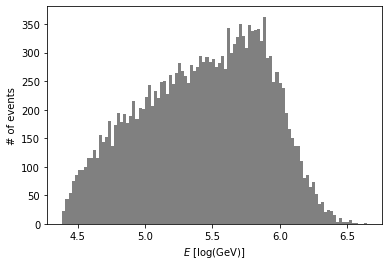

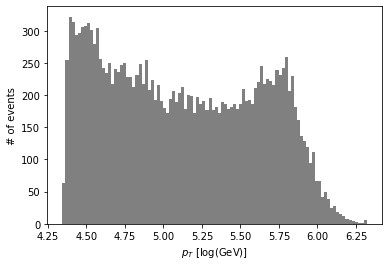

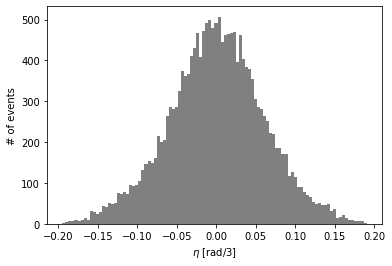

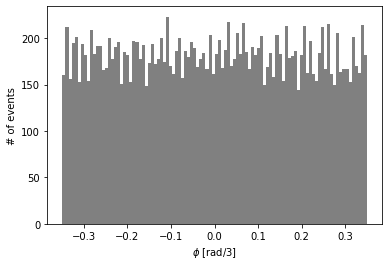

In [34]:
import matplotlib.pyplot as plt

unit_list = ['[log(GeV)]','[log(GeV)]', '[rad/3]', '[rad/3]' ]
variable_list = [r'$E$', r'$p_T$', r'$\eta$', r'$\phi$']

branches=["E","pt","eta","phi"]

n_bins = 100

for kk in range(0,4):
    n_hist_data, bin_edges, _ = plt.hist(train[branches[kk]], color='gray', label='Input', alpha=1, bins=n_bins)
    plt.xlabel(xlabel=variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('# of events')
    #plt.savefig("fourmomentum_"+branches[kk],dpi=300)
    plt.show()

In [35]:
#installing fastai v2.0
pip install fastai --upgrade

Requirement already up-to-date: fastai in /usr/local/lib/python3.7/dist-packages (2.2.7)


## Setting up the network

### Preparing the data

Adding the two datasets as TensorDatasets to PyTorch (also loading all other classes we'll need later)

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core

train_x = train
test_x = test
train_y = train_x  # y = x since we are building an autoencoder
test_y = test_x

# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

We now set things up to load the data, and we use a batch size that was optimized by previous students...note also that this is fastai v2, migration thanks to Jessica Lastow.

In [48]:
bs = 100

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

### Preparing the network

Here we have an example network. Details aren't too important, as long as they match what was already trained for us...in this case we have a LeakyReLU, tanh activation function, and a number of layers that goes from 4 to 200 to 20 to 3 (number of features in the hidden layer that we pick for testing compression) and then back all the way to 4. 

In [49]:
class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, 3)
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'

model = AE_3D_200_LeakyReLU()
model.to('cpu')

AE_3D_200_LeakyReLU(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=20, bias=True)
  (en4): Linear(in_features=20, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=20, bias=True)
  (de2): Linear(in_features=20, out_features=200, bias=True)
  (de3): Linear(in_features=200, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

We now have to pick a loss function - MSE loss is appropriate for a compression autoencoder since it reflects the [(input-output)/input] physical quantity that we want to minimize. 

In [50]:
from fastai.metrics import mse

loss_func = nn.MSELoss()

#bn_wd = False  # Don't use weight decay for batchnorm layers
#true_wd = True  # weight decay will be used for all optimizers
wd = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=recorder)
#was: learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

## Alternative 1: Running a pre-trained network

Now we load the pre-trained network. 

In [51]:
#learn.load("4D_TLA_leading")

Then we evaluate the MSE on this network - it should be of the order of 0.001 or less if all has gone well...if it has not trained as well (note the pesky 0-mass peak above...) then it's going to be a bit higher.

In [52]:
#learn.validate()

## Alternative 2: Training a new network

Instead of using a pre-trained network, an alternative is to train a new network and use that instead. 

First, we want to find the best learning rate. The learning rate is a hyper-paramater that sets how much the weights of the network will change each step with respect to the loss gradient.

Then we plot the loss versus the learning rates. We're interested in finding a good order of magnitude of learning rate, so we plot with a log scale.

A good value for the learning rates is then either:
- one tenth of the minimum before the divergence
- when the slope is the steepest

Learning rate with the minimum loss: 0.014454397559165954
Learning rate with the steepest gradient: 0.0020892962347716093


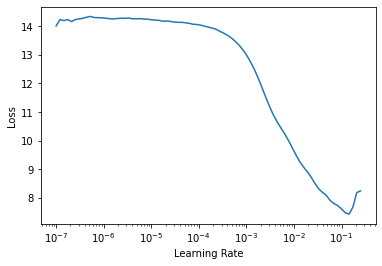

In [53]:
from fastai.callback import schedule

lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

Now we want to run the training!

User-chosen variables:
- n_epoch: The number of epochs, i.e how many times the to run through all of the training data once (i.e the 1266046 entries, see cell 2)
- lr: The learning rate. Either choose lr_min, lr_steep from above or set your own.


In [54]:
import time
start = time.perf_counter() # Starts timer
learn.fit_one_cycle(n_epoch=30, lr_max=lr_min)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

[0, 0.23867549002170563, 0.12524302303791046, '00:01']
[0, 0.23867549002170563, 0.12524302303791046, '00:01']
[1, 0.12902525067329407, 0.1287783980369568, '00:01']
[1, 0.12902525067329407, 0.1287783980369568, '00:01']
[2, 0.13051842153072357, 0.11494874954223633, '00:01']
[2, 0.13051842153072357, 0.11494874954223633, '00:01']
[3, 0.05331626534461975, 0.0588376559317112, '00:01']
[3, 0.05331626534461975, 0.0588376559317112, '00:01']
[4, 0.04206385836005211, 0.02751656249165535, '00:01']
[4, 0.04206385836005211, 0.02751656249165535, '00:01']
[5, 0.055976077914237976, 0.04117828980088234, '00:01']
[5, 0.055976077914237976, 0.04117828980088234, '00:01']
[6, 0.05717558413743973, 0.04651699587702751, '00:01']
[6, 0.05717558413743973, 0.04651699587702751, '00:01']
[7, 0.7646217346191406, 0.12752848863601685, '00:01']
[7, 0.7646217346191406, 0.12752848863601685, '00:01']
[8, 0.1493600755929947, 0.182745561003685, '00:01']
[8, 0.1493600755929947, 0.182745561003685, '00:01']
[9, 0.15068820118904

Then we plot the loss as a function of batches and epochs to check if we reach a plateau.

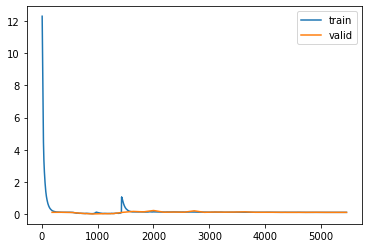

In [55]:
recorder.plot_loss()


Then we evaluate the MSE on this network - it should be of the order of 0.001 or less if all has gone well...if it has not trained as well (note the pesky 0-mass peak above...) then it's going to be a bit higher.

In [56]:

learn.validate()

(#1) [0.12361691147089005]

Let's plot all of this, with ratios 

## Plotting the outputs of the network

Lazy-save of our output files (they'll also be on screen)

In [57]:
import os
save_dir = "plotOutput"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

A function in case we want to un-normalize and get back to physical quantities...

In [58]:
def custom_unnormalize(df):
    df['eta'] = df['eta'] * 5
    df['phi'] = df['phi'] * 3
    df['E'] = 10**df['E']
    df['pt'] = 10**(df['pt'])
    return df

Make the histograms from the dataset...

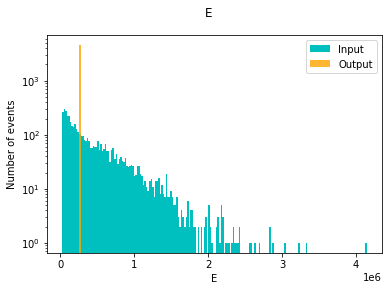

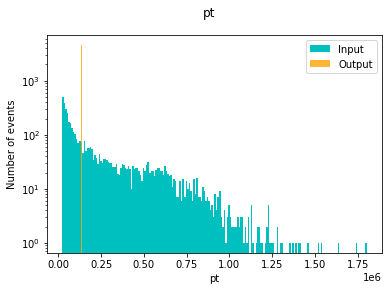

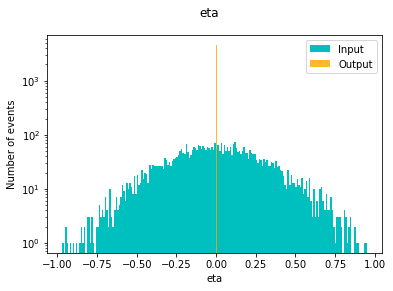

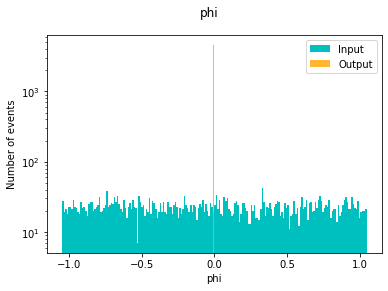

In [59]:
import numpy as np

plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

save = False # Option to save figure

# Histograms
idxs = (0, 4533)  # Choose events to compare
data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float)
#data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float).double()
pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

data_df = pd.DataFrame(data, columns=test.columns)
pred_df = pd.DataFrame(pred, columns=test.columns)

unnormalized_data_df = custom_unnormalize(data_df)
unnormalized_pred_df = custom_unnormalize(pred_df)    
    
alph = 0.8
n_bins = 200
for kk in np.arange(4):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(test.columns[kk])
    plt.xlabel(test.columns[kk])
    plt.ylabel('Number of events')
    # ms.sciy()
    plt.yscale('log')
    if save:
        plt.savefig(os.path.join(save_dir,test.columns[kk]+'.png'))
    plt.legend()


    


In [61]:
def getRatio(bin1,bin2):
    bins = []
    for b1,b2 in zip(bin1,bin2):
        if b1==0 and b2==0:
            bins.append(0.)
        elif b2==0:
            bins.append(None)
        else:
            bins.append((float(b2)-float(b1))/b1)
    return bins   

rat = getRatio(n_hist_data,n_hist_pred)
#print(rat)